# Project: Metadata Suggesties voor Online Lesmateriaal

##1. Inleiding
In dit ptoject dat we gaan uitvoeren voor de organisatie Wikiwijs is ons doel om metdatasuggesties voor het online lesmateriaal van Wikiwijs te gaan maken. We willen dat ons model uiteindelijk accurate metadata suggesties gaat geven voor het leerjaar, het niveau en het vak.

## 2. Gegevens Onderzoeken en Begrijpen

In deze sectie verkennen we de structuur van onze dataset. We richten ons op JSON-bestanden die lesmateriaal bevatten, specifiek op het bestand vmbo1.json in de submap 'Bio'.

In [164]:
import os
import json

# Specificeer het pad naar de submap 'Bio' waar 'vmbo1.json' zich bevindt
directory_path = '/Users/lucao/Downloads/json_files'

# Bestandsnaam van het voorbeeld JSON-bestand
file_name = '13.json'
file_path = os.path.join(directory_path, file_name)

# Lees het JSON-bestand en print de inhoud om de structuur te begrijpen
try:
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        print(json.dumps(data, indent=4))  # Print de inhoud met een nette indeling
except Exception as e:
    print(f"Error bij het lezen van bestand {file_name}: {e}")


{
    "documentAuthors": [
        "Marjolein Kalter"
    ],
    "uuid": null,
    "authors": [
        {
            "fullName": "Marjolein Kalter",
            "referenceName": null,
            "reference": {
                "value": "6"
            },
            "firstName": "Marjolein",
            "infix": "",
            "lastName": "Kalter",
            "emailAddress": "marjolein@anderszins.com",
            "type": "author"
        }
    ],
    "documentDate": "2010-02-08T15:52:23Z",
    "bulkId": "bulk-17041135-refresh_all",
    "identifier": 13,
    "title": "Vormgeven van je arrangement",
    "description": "Instructie hoe de vormgeving van een arrangement aan te passen is",
    "lastModifiedDate": "2010-02-08T15:52:23+01:00",
    "dateCreated": "2009-10-27T17:09:40+01:00",
    "published": true,
    "publisher": null,
    "team": {
        "reference": {
            "value": "wikiwijs_maken_authors"
        },
        "name": "Wikiwijs Maken Auteurs",
        "members": [

**Analyse van vmbo1.json Inhoud**
De JSON-data van vmbo1.json biedt een diepgaand inzicht in het structuur en inhoud van het online lesmateriaal voor het thema "Omgeving" voor vmbo-b12. Hieronder volgt een gedetailleerde analyse van de sleutelcomponenten binnen het bestand:

**Metadata en Auteursinformatie**
Document Auteurs: Het document bevat namen van diverse auteurs, waaronder Pieter Bruring en Sophia Kambakhsh, die bijdragen hebben geleverd aan de inhoud
.

Publicatiedatum: De inhoud is laatst gewijzigd op 25 mei 2023, wat aangeeft dat het materiaal recent is bijgewerkt.


Licentie: Het materiaal valt onder de "CC Naamsvermelding-GelijkDelen 4.0 Internationale licentie", wat betekent dat gebruikers het werk mogen kopiëren, verspreiden, doorgeven, en afgeleide werken mogen maken onder bepaalde voorwaarden.


**Inhoud en Structuur**
Titel: "Thema Omgeving vmbo-b12" geeft duidelijk het onderwerp en het doelpubliek van het lesmateriaal aan.


Beschrijving: Er is een korte inleiding die het thema en de kernonderwerpen beschrijft, zoals levenskenmerken en voedselketens.


Secties: Het document is opgedeeld in verschillende secties, zoals "Intro", "Wat kan ik straks?", en "Wat ga ik doen?", die elk specifieke leerdoelen en activiteiten bevatten. Dit wijst op een gestructureerde benadering om de leerinhoud te presenteren.


**Educatieve Componenten**
Leerdoelen: Voor elke sectie worden specifieke leerdoelen vermeld, zoals het kunnen noemen van negen levenskenmerken en het beschrijven van de begrippen voedselketen en voedselweb.


Opdrachten: Er zijn diverse opdrachten opgenomen met duidelijke instructies en verwachte leeruitkomsten, wat bijdraagt aan een interactieve leerervaring.


Multimedia-inhoud: Het gebruik van afbeeldingen en ingesloten video's verrijkt de tekstuele inhoud en biedt een meer boeiende leerervaring.


**Reflectie en Evaluatie**
Diagnostische toets: Aan het eind van het thema is er een diagnostische toets om de kennis van de leerlingen te evalueren, wat essentieel is voor het beoordelen van het begrip van de leerstof.


Terugkijken: Er is een sectie gewijd aan zelfreflectie, waar leerlingen worden aangemoedigd om na te denken over wat ze hebben geleerd en hoe het proces is verlopen.


**Conclusie**
De inhoud van vmbo1.json toont een goed doordacht en uitgebreid lesmateriaal dat zorgvuldig is ontworpen om vmbo-b12 leerlingen te onderwijzen over het thema "Omgeving". De combinatie van gestructureerde informatie, duidelijke leerdoelen, interactieve opdrachten, en multimedia-inhoud maakt dit een waardevolle bron voor zowel leerlingen als docenten.

##2. Bouw een Input Datapipeline voor Tekst-Preprocessing

We gebruiken BeautifulSoup om HTML-content te verwijderen en reguliere expressies (re) om overbodige spaties te verwijderen. Vervolgens extraheren we de tekst uit elke sectie van onze JSON-bestanden.


In [165]:
from bs4 import BeautifulSoup
import re

def clean_html(raw_html):
    """Functie om HTML-content te verwerken en overbodige spaties te verwijderen."""
    soup = BeautifulSoup(raw_html, "html.parser")
    text = soup.get_text(separator=' ')
    text = re.sub('\s+', ' ', text).strip()
    return text

def extract_text_from_section(section):
    """Functie om inhoud uit secties te halen, inclusief subsecties."""
    text = section.get('heading', {}).get('content', '') + " "
    for item in section.get('items', []):
        text += item.get('content', '') + " "
    for subsection in section.get('sections', []):
        text += extract_text_from_section(subsection)
    return text


Nu we onze functies voor het schoonmaken en extraheren van tekst hebben, kunnen we deze toepassen op onze dataset. We lezen elk JSON-bestand uit onze dataset, extraheren de tekst met behulp van onze functies, en slaan de schone teksten op voor verdere verwerking.




In [166]:
import os
import json

# Map waarin alle vakmappen zijn opgeslagen
directory_path = '/Users/lucao/Downloads/json_files'

# Lijst om alle geëxtraheerde teksten op te slaan
all_texts = []

# Itereren over alle submappen (vakmappen)
for subdir in os.listdir(directory_path):
    subdirectory_path = os.path.join(directory_path, subdir)
    if os.path.isdir(subdirectory_path):
        for filename in os.listdir(subdirectory_path):
            if filename.endswith('.json'):
                file_path = os.path.join(subdirectory_path, filename)
                try:
                    with open(file_path, 'r', encoding='utf-8') as file:
                        data = json.load(file)
                    processed_text = clean_html(extract_text_from_section(data))
                    all_texts.append(processed_text)
                except Exception as e:
                    print(f"Fout bij het verwerken van bestand {filename}: {e}")

# Weergeven van de geëxtraheerde teksten
print(all_texts)


[]


Met deze pipeline voor tekst-preprocessing hebben we nu een schone, gestructureerde tekstinput die kan worden gebruikt voor verdere verwerking, zoals feature extractie of direct in een machine learning model. doordat deze functie iterateert over alle submappen zullen de lessen voor elk vak worden meegenomen.

In [167]:
def compare_texts(raw_html):
    """Functie om de originele en opgeschoonde tekst naast elkaar te tonen."""
    print("Originele Tekst:")
    print(raw_html)
    print("\nOpgeschoonde Tekst:")
    cleaned_text = clean_html(raw_html)
    print(cleaned_text)

# Voorbeeld HTML-tekst
raw_html_example = "<div>Dit is een <b>voorbeeld</b> tekst met <a href='https://example.com'>een link</a> en wat andere <i>HTML</i> elementen.<br />En een nieuwe regel.</div>"

# Vergelijk de originele met de opgeschoonde tekst
compare_texts(raw_html_example)


Originele Tekst:
<div>Dit is een <b>voorbeeld</b> tekst met <a href='https://example.com'>een link</a> en wat andere <i>HTML</i> elementen.<br />En een nieuwe regel.</div>

Opgeschoonde Tekst:
Dit is een voorbeeld tekst met een link en wat andere HTML elementen. En een nieuwe regel.


In [168]:
import tensorflow as tf

# Omzetten van de lijst met opgeschoonde teksten naar een TensorFlow Dataset
texts_dataset = tf.data.Dataset.from_tensor_slices(all_texts)

# Voorbeeld om de eerste paar elementen van de dataset te bekijken
for text in texts_dataset.take(3):
    print(text.numpy())


2024-05-16 15:54:02.443808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [169]:
class ETLPipeline:
    VALID_SUBJECTS = {
        "Aardrijkskunde", "Algemene natuurwetenschappen", "Arabisch", 
        "Audiovisuele vormgeving", "Beeldende vormgeving", "Bewegen, sport en maatschappij", 
        "Biologie", "Chinees", "Culturele en kunstzinnige vorming", 
        "Dans", "Drama", "Duits", "Economie", "Engels", "Filosofie",
        "Frans", "Fries", "Geschiedenis", "Godsdienst", "Grieks", 
        "Handvaardigheid", "Informatica", "Italiaans", "Klassieke culturele vorming", 
        "Kunst algemeen", "Kunst en cultuur", "Latijn", "Levensbeschouwing", 
        "Lichamelijke opvoeding", "Lichamelijke opvoeding (gemeenschappelijk deel)", 
        "Literatuur", "Maatschappijleer", "Maatschappijleer (gemeenschappelijk deel)", 
        "Maatschappijwetenschappen", "Management en organisatie", "Mens en maatschappij", 
        "Mens en natuur", "Muziek", "NaSk", "NaSk1", "NaSk2", 
        "Natuur, leven en technologie", "Natuur- en milieueducatie", "Natuurkunde", 
        "Nederlands", "Nederlands als tweede taal", "Portugees", 
        "Rekenen/wiskunde", "Russisch", "Scheikunde", "Spaans", "Techniek", 
        "Tekenen", "Textiele vormgeving", "Turks", "Verzorging", "Wiskunde A", 
        "Wiskunde B", "Wiskunde C", "Wiskunde D"
    }
    
    def __init__(self, directory_path):
        self.directory_path = directory_path
        self.all_texts = []
        self.vakken = []
        self.leerjaren = []
        self.niveaus = []

    def clean_html(self, raw_html):
        soup = BeautifulSoup(raw_html, "html.parser")
        text = soup.get_text(separator=' ')
        text = re.sub('\s+', ' ', text).strip()
        return text

    def extract_text_from_section(self, section):
        text = section.get('heading', {}).get('content', '') + " "
        for item in section.get('items', []):
            text += item.get('content', '') + " "
        for subsection in section.get('sections', []):
            text += self.extract_text_from_section(subsection)
        return text

    def extract_text(self):
        for subdir, _, files in os.walk(self.directory_path):
            for filename in files:
                if filename.endswith('.json'):
                    file_path = os.path.join(subdir, filename)
                    try:
                        with open(file_path, 'r', encoding='utf-8') as file:
                            data = json.load(file)
                        processed_text = self.clean_html(self.extract_text_from_section(data))
                        self.all_texts.append(processed_text)
                        self.extract_metadata(data)  # Extract metadata
                    except Exception as e:
                        print(f"Error processing file {filename}: {e}")

    def extract_metadata(self, data):
        vakken_set = set()
        leerjaren_set = set()
        niveaus_set = set()

        for term in data.get('colophon', {}).get('metadata', []):
            if not isinstance(term, dict):
                print(f"Issue with metadata entry: {term}")
                continue

            key = term.get('key')
            terms = term.get('terms')

            if key == 'disciplines':
                if terms is not None and isinstance(terms, (dict, list)):
                    if isinstance(terms, dict):
                        elements = terms.values()
                    else:
                        elements = terms
                    for element in elements:
                        vakken_set.update(map(lambda x: x.strip(), element.split(',')))
                else:
                    print(f"Issue with 'disciplines' metadata: {terms}")
            elif key == 'educationalLevels':
                if terms is not None and isinstance(terms, dict):
                    for value in terms.values():
                        if value is not None:
                            leerjaren_set.update(re.findall(r'\b\d+\b', value))
                            levels = map(lambda x: x.strip(), value.split(','))
                            niveaus_set.update(levels)
                else:
                    print(f"Issue with 'educationalLevels' metadata: {terms}")

        vakken_set = vakken_set.intersection(self.VALID_SUBJECTS)
        
        self.vakken.append(', '.join(sorted(vakken_set)))
        self.leerjaren.append(', '.join(sorted(leerjaren_set, key=int)))
        self.niveaus.append(', '.join(sorted(niveaus_set)))
    
    def create_dataframe(self):
        df = pd.DataFrame({'text': self.all_texts, 
                           'vakken': self.vakken, 
                           'leerjaren': self.leerjaren, 
                           'niveaus': self.niveaus})
    
        df = df[df['vakken'] != '']
        return df

# Usage
directory_path = '/Users/lucao/Downloads/json_files'
pipeline = ETLPipeline(directory_path)
pipeline.extract_text()
dataframe = pipeline.create_dataframe()

print(dataframe.head())

/var/folders/9s/4gqp5v9d55j7s5xh2l8z7qp00000gn/T/ipykernel_23751/2883053163.py:29: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(raw_html, "html.parser")


                                                 text  \
0   Een dag zonder elektriciteit Intro Wat hebben ...   
2   Hier staat uitleg over de leerstof van havo5 s...   
12  Introductie en afspraken CKV Mavo 3 CKV Een ni...   
15  Eureka Inleiding Eureka! Ik heb het gevonden! ...   
17  Introductie 'Oorlog begint in de hoofden van m...   

                                               vakken         leerjaren  \
0                                      Aardrijkskunde              3, 4   
2                                          Scheikunde                 5   
12  Audiovisuele vormgeving, Dans, Drama, Handvaar...                 3   
15                             Literatuur, Nederlands              1, 2   
17  Aardrijkskunde, Geschiedenis, Godsdienst, Maat...  1, 2, 3, 4, 5, 6   

                                              niveaus  
0   3, 4, VMBO gemengde leerweg, VMBO kaderberoeps...  
2                                              HAVO 5  
12                       3, VMBO theor

In [170]:
dataframe

,text,vakken,leerjaren,niveaus
0,Een dag zonder elektriciteit Intro Wat hebben ...,Aardrijkskunde,"3, 4","3, 4, VMBO gemengde leerweg, VMBO kaderberoeps..."
2,Hier staat uitleg over de leerstof van havo5 s...,Scheikunde,5,HAVO 5
12,Introductie en afspraken CKV Mavo 3 CKV Een ni...,"Audiovisuele vormgeving, Dans, Drama, Handvaar...",3,"3, VMBO theoretische leerweg"
15,Eureka Inleiding Eureka! Ik heb het gevonden! ...,"Literatuur, Nederlands","1, 2","HAVO 1, HAVO 2, VWO 1, VWO 2"
17,Introductie 'Oorlog begint in de hoofden van m...,"Aardrijkskunde, Geschiedenis, Godsdienst, Maat...","1, 2, 3, 4, 5, 6","1, 2, 3, 4, HAVO 1, HAVO 2, HAVO 3, HAVO 4, HA..."
...,...,...,...,...
13461,Zu3D Oktober 2017 Lieke Gradussen Workshop Zu3...,Informatica,,HBO - Bachelor
13462,Wat is erfelijk? Intro Een gezin met kinderen....,Biologie,"1, 2","1, 2, VMBO gemengde leerweg, VMBO kaderberoeps..."
13469,Thema Inleiding Inleiding In de tijd dat je op...,Rekenen/wiskunde,2,"2, VMBO gemengde leerweg, VMBO kaderberoepsger..."
13470,Algemeen Planning schooljaar 2017 - 2018 In ha...,"Literatuur, Nederlands",4,HAVO 4


In [171]:
empty_vakken_rows = dataframe[dataframe['vakken'] == '']
empty_vakken_rows.head(10)



,text,vakken,leerjaren,niveaus


## Kleine EDA

In [172]:
df = dataframe
df

,text,vakken,leerjaren,niveaus
0,Een dag zonder elektriciteit Intro Wat hebben ...,Aardrijkskunde,"3, 4","3, 4, VMBO gemengde leerweg, VMBO kaderberoeps..."
2,Hier staat uitleg over de leerstof van havo5 s...,Scheikunde,5,HAVO 5
12,Introductie en afspraken CKV Mavo 3 CKV Een ni...,"Audiovisuele vormgeving, Dans, Drama, Handvaar...",3,"3, VMBO theoretische leerweg"
15,Eureka Inleiding Eureka! Ik heb het gevonden! ...,"Literatuur, Nederlands","1, 2","HAVO 1, HAVO 2, VWO 1, VWO 2"
17,Introductie 'Oorlog begint in de hoofden van m...,"Aardrijkskunde, Geschiedenis, Godsdienst, Maat...","1, 2, 3, 4, 5, 6","1, 2, 3, 4, HAVO 1, HAVO 2, HAVO 3, HAVO 4, HA..."
...,...,...,...,...
13461,Zu3D Oktober 2017 Lieke Gradussen Workshop Zu3...,Informatica,,HBO - Bachelor
13462,Wat is erfelijk? Intro Een gezin met kinderen....,Biologie,"1, 2","1, 2, VMBO gemengde leerweg, VMBO kaderberoeps..."
13469,Thema Inleiding Inleiding In de tijd dat je op...,Rekenen/wiskunde,2,"2, VMBO gemengde leerweg, VMBO kaderberoepsger..."
13470,Algemeen Planning schooljaar 2017 - 2018 In ha...,"Literatuur, Nederlands",4,HAVO 4


Wij zien in deze dataframe dat er lessen zijn voor PO, met leerjaar 1-8. Wij willen alleen lessen uit het voortgezet onderwijs.

In [173]:
# Assuming df is your DataFrame
df.drop(df[df['niveaus'].str.contains('PO groep') | df['niveaus'].str.contains('HBO - Bachelor')].index, inplace=True)


Nu kunnen we deze PO content uit de dataset halen.

In [174]:
df



,text,vakken,leerjaren,niveaus
0,Een dag zonder elektriciteit Intro Wat hebben ...,Aardrijkskunde,"3, 4","3, 4, VMBO gemengde leerweg, VMBO kaderberoeps..."
2,Hier staat uitleg over de leerstof van havo5 s...,Scheikunde,5,HAVO 5
12,Introductie en afspraken CKV Mavo 3 CKV Een ni...,"Audiovisuele vormgeving, Dans, Drama, Handvaar...",3,"3, VMBO theoretische leerweg"
15,Eureka Inleiding Eureka! Ik heb het gevonden! ...,"Literatuur, Nederlands","1, 2","HAVO 1, HAVO 2, VWO 1, VWO 2"
17,Introductie 'Oorlog begint in de hoofden van m...,"Aardrijkskunde, Geschiedenis, Godsdienst, Maat...","1, 2, 3, 4, 5, 6","1, 2, 3, 4, HAVO 1, HAVO 2, HAVO 3, HAVO 4, HA..."
...,...,...,...,...
13458,Cultuur Intro Een volk bestaat uit mensen met ...,Aardrijkskunde,"1, 2","1, 2, VMBO basisberoepsgerichte leerweg, VMBO ..."
13462,Wat is erfelijk? Intro Een gezin met kinderen....,Biologie,"1, 2","1, 2, VMBO gemengde leerweg, VMBO kaderberoeps..."
13469,Thema Inleiding Inleiding In de tijd dat je op...,Rekenen/wiskunde,2,"2, VMBO gemengde leerweg, VMBO kaderberoepsger..."
13470,Algemeen Planning schooljaar 2017 - 2018 In ha...,"Literatuur, Nederlands",4,HAVO 4


In [175]:
extracted_data

[{'leerjaren': '3, 4',
  'niveau': 'VMBO gemengde leerweg, VMBO kaderberoepsgerichte leerweg, VMBO theoretische leerweg',
  'vak': 'Aardrijkskunde, Duurzaamheid, Globalisering, Middelen van bestaan, Natuurlijke hulpbronnen en bronnen van energie'},
 {'leerjaren': '', 'niveau': '', 'vak': ''},
 {'leerjaren': '5', 'niveau': 'HAVO 5', 'vak': 'Scheikunde'},
 {'leerjaren': '', 'niveau': '', 'vak': 'Duitse taal en cultuur'},
 {'leerjaren': '3',
  'niveau': 'VMBO theoretische leerweg',
  'vak': 'Audiovisuele vormgeving, Dans, Drama, Handvaardigheid, Kunst en cultuur, Muziek, Tekenen, Textiele vormgeving'},
 {'leerjaren': '1, 2',
  'niveau': 'HAVO 1, HAVO 2, VWO 1, VWO 2',
  'vak': 'Begrippenlijst en taalverzorging, Lezen van fictionele teksten en literaire teksten (Nederlands), Literatuur, Nederlands, Schrijfvaardigheid, Schrijven, Woordgebruik en woordenschat (Nederlands)'},
 {'leerjaren': '1, 2, 3, 4, 5, 6',
  'niveau': 'HAVO 1, HAVO 2, HAVO 3, HAVO 4, HAVO 5, Praktijkonderwijs, VMBO basisb

In [176]:
# Assuming df is your DataFrame
df.drop(df[df['niveaus'].str.contains('PO groep') | df['niveaus'].str.contains('HBO - Bachelor')].index, inplace=True)

df.head()

,text,vakken,leerjaren,niveaus
0,Een dag zonder elektriciteit Intro Wat hebben ...,Aardrijkskunde,"3, 4","3, 4, VMBO gemengde leerweg, VMBO kaderberoeps..."
2,Hier staat uitleg over de leerstof van havo5 s...,Scheikunde,5,HAVO 5
12,Introductie en afspraken CKV Mavo 3 CKV Een ni...,"Audiovisuele vormgeving, Dans, Drama, Handvaar...",3,"3, VMBO theoretische leerweg"
15,Eureka Inleiding Eureka! Ik heb het gevonden! ...,"Literatuur, Nederlands","1, 2","HAVO 1, HAVO 2, VWO 1, VWO 2"
17,Introductie 'Oorlog begint in de hoofden van m...,"Aardrijkskunde, Geschiedenis, Godsdienst, Maat...","1, 2, 3, 4, 5, 6","1, 2, 3, 4, HAVO 1, HAVO 2, HAVO 3, HAVO 4, HA..."


In [177]:
df[df['vakken'].str.contains('Duitse taal en cultuur')].head(10)

,text,vakken,leerjaren,niveaus


/var/folders/9s/4gqp5v9d55j7s5xh2l8z7qp00000gn/T/ipykernel_23751/3207043549.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


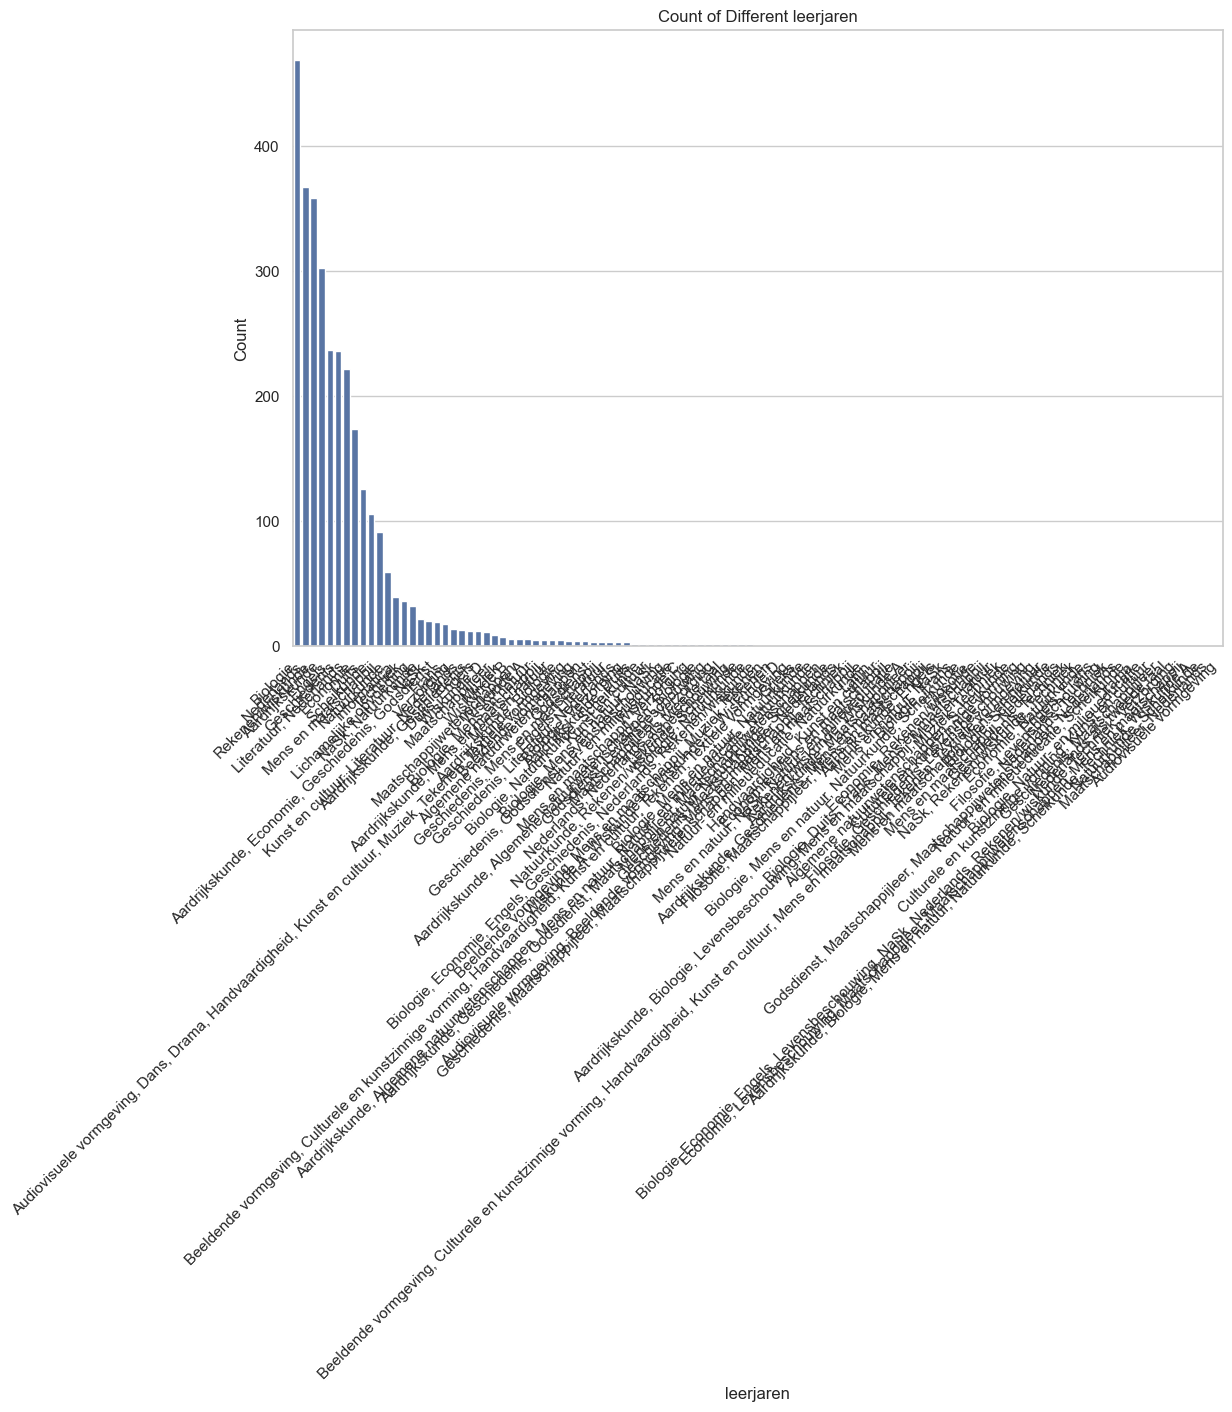

In [178]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the plot
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.countplot(data=dataframe, x='vakken', order=dataframe['vakken'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.xlabel('leerjaren')
plt.ylabel('Count')
plt.title('Count of Different leerjaren')
plt.tight_layout()
plt.show()


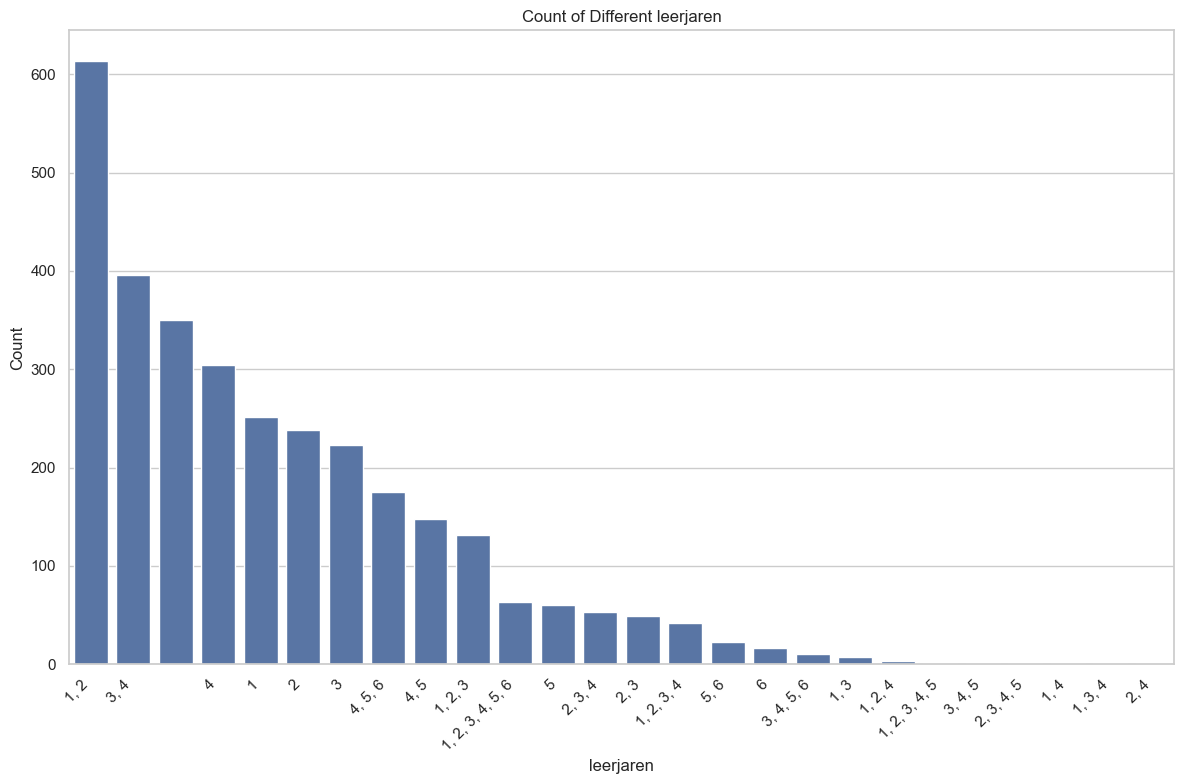

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the plot
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='leerjaren', order=df['leerjaren'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.xlabel('leerjaren')
plt.ylabel('Count')
plt.title('Count of Different leerjaren')
plt.tight_layout()
plt.show()


We zien dat veel jeerlaren samen zijn (1,2)

In [180]:
# Assuming df is your DataFrame
vakken_list = dataframe['vakken'].unique()
print(vakken_list)


['Aardrijkskunde' 'Scheikunde'
 'Audiovisuele vormgeving, Dans, Drama, Handvaardigheid, Kunst en cultuur, Muziek, Tekenen, Textiele vormgeving'
 'Literatuur, Nederlands'
 'Aardrijkskunde, Geschiedenis, Godsdienst, Maatschappijleer, Maatschappijwetenschappen'
 'Maatschappijwetenschappen' 'Rekenen/wiskunde' 'Biologie' 'Nederlands'
 'Duits' 'Geschiedenis, Literatuur, Nederlands' 'Geschiedenis' 'Economie'
 'Mens en maatschappij' 'Engels' 'Wiskunde D'
 'Kunst en cultuur, Literatuur, Nederlands' 'Informatica'
 'Levensbeschouwing' 'NaSk' 'NaSk, Natuurkunde'
 'Aardrijkskunde, Geschiedenis' 'Natuurkunde' 'Techniek'
 'Aardrijkskunde, Economie, Geschiedenis, Godsdienst'
 'Geschiedenis, Maatschappijleer, Nederlands' 'Mens en natuur'
 'Aardrijkskunde, Biologie' 'Lichamelijke opvoeding'
 'Biologie, Natuurkunde' 'Maatschappijleer, Verzorging'
 'Biologie, Mens en natuur' 'Duits, Engels' 'Muziek'
 'Nederlands als tweede taal' 'Beeldende vormgeving'
 'Culturele en kunstzinnige vorming, Kunst en cultuur'

In [181]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np

valid_subjects = [
    "Aardrijkskunde", "Algemene natuurwetenschappen", "Arabisch", 
    "Audiovisuele vormgeving", "Beeldende vormgeving", "Bewegen, sport en maatschappij", 
    "Biologie", "Chinees", "Culturele en kunstzinnige vorming", 
    "Dans", "Drama", "Duits", "Economie", "Engels", "Filosofie",
    "Frans", "Fries", "Geschiedenis", "Godsdienst", "Grieks", 
    "Handvaardigheid", "Informatica", "Italiaans", "Klassieke culturele vorming", 
    "Kunst algemeen", "Kunst en cultuur", "Latijn", "Levensbeschouwing", 
    "Lichamelijke opvoeding", "Literatuur", "Maatschappijleer", 
    "Maatschappijwetenschappen", "Management en organisatie", "Mens en maatschappij", 
    "Mens en natuur", "Muziek", "NaSk", "NaSk1", "NaSk2", 
    "Natuur, leven en technologie", "Natuur- en milieueducatie", "Natuurkunde", 
    "Nederlands", "Portugees", "Rekenen/wiskunde", 
    "Russisch", "Scheikunde", "Spaans", "Techniek", 
    "Tekenen", "Textiele vormgeving", "Turks", "Verzorging", 
    "Wiskunde A", "Wiskunde B", "Wiskunde C", "Wiskunde D"
]

def clean_vakken(vakken_list, valid_subjects):
    cleaned_vakken = []
    for vakken in vakken_list:
        subjects = [sub.strip() for sub in vakken.split(",")]
        found_subject = None
        for subject in subjects:
            if subject in valid_subjects:
                found_subject = subject
                break  # Take the first valid subject found
        if found_subject:
            cleaned_vakken.append(found_subject)
        else:
            cleaned_vakken.append(None)  # Mark as None to filter out later
    return cleaned_vakken

# Apply the cleaning function to the vakken column
dataframe['cleaned_vakken'] = clean_vakken(dataframe['vakken'].tolist(), valid_subjects)

# Filter out rows where the cleaned_vakken column is None
dataframe = dataframe.dropna(subset=['cleaned_vakken'])

 

In [182]:
dataframe

,text,vakken,leerjaren,niveaus,cleaned_vakken
0,Een dag zonder elektriciteit Intro Wat hebben ...,Aardrijkskunde,"3, 4","3, 4, VMBO gemengde leerweg, VMBO kaderberoeps...",Aardrijkskunde
2,Hier staat uitleg over de leerstof van havo5 s...,Scheikunde,5,HAVO 5,Scheikunde
12,Introductie en afspraken CKV Mavo 3 CKV Een ni...,"Audiovisuele vormgeving, Dans, Drama, Handvaar...",3,"3, VMBO theoretische leerweg",Audiovisuele vormgeving
15,Eureka Inleiding Eureka! Ik heb het gevonden! ...,"Literatuur, Nederlands","1, 2","HAVO 1, HAVO 2, VWO 1, VWO 2",Literatuur
17,Introductie 'Oorlog begint in de hoofden van m...,"Aardrijkskunde, Geschiedenis, Godsdienst, Maat...","1, 2, 3, 4, 5, 6","1, 2, 3, 4, HAVO 1, HAVO 2, HAVO 3, HAVO 4, HA...",Aardrijkskunde
...,...,...,...,...,...
13458,Cultuur Intro Een volk bestaat uit mensen met ...,Aardrijkskunde,"1, 2","1, 2, VMBO basisberoepsgerichte leerweg, VMBO ...",Aardrijkskunde
13462,Wat is erfelijk? Intro Een gezin met kinderen....,Biologie,"1, 2","1, 2, VMBO gemengde leerweg, VMBO kaderberoeps...",Biologie
13469,Thema Inleiding Inleiding In de tijd dat je op...,Rekenen/wiskunde,2,"2, VMBO gemengde leerweg, VMBO kaderberoepsger...",Rekenen/wiskunde
13470,Algemeen Planning schooljaar 2017 - 2018 In ha...,"Literatuur, Nederlands",4,HAVO 4,Literatuur


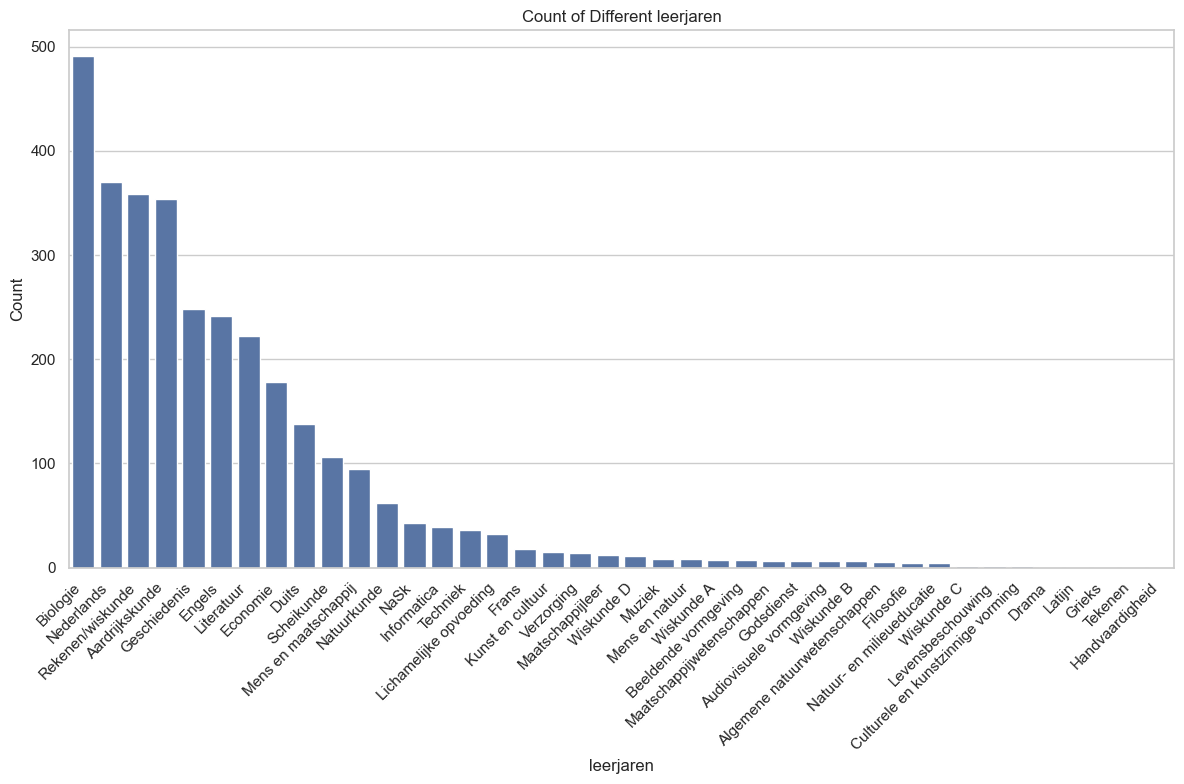

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the plot
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.countplot(data=dataframe, x='cleaned_vakken', order=dataframe['cleaned_vakken'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.xlabel('leerjaren')
plt.ylabel('Count')
plt.title('Count of Different leerjaren')
plt.tight_layout()
plt.show()


In [184]:
dataframe['text']

0        Een dag zonder elektriciteit Intro Wat hebben ...
2        Hier staat uitleg over de leerstof van havo5 s...
12       Introductie en afspraken CKV Mavo 3 CKV Een ni...
15       Eureka Inleiding Eureka! Ik heb het gevonden! ...
17       Introductie 'Oorlog begint in de hoofden van m...
                               ...                        
13458    Cultuur Intro Een volk bestaat uit mensen met ...
13462    Wat is erfelijk? Intro Een gezin met kinderen....
13469    Thema Inleiding Inleiding In de tijd dat je op...
13470    Algemeen Planning schooljaar 2017 - 2018 In ha...
13484    Thema Evolutie Intro Evolutie Het leven op aar...
Name: text, Length: 3162, dtype: object

# Keywords van Vakken

In [185]:
# Luca
biologie_keywords = ['omgeving', 'ordenen', 'blessures', 'organismen', 'geraamte', 'beenderen', 'lichaamshouding', 'zintuigen', 'zenuwstelsel', 'ogen', 'fotosynthese', 'voortplanting', 'zaad', 'eetgewoontes', 'voedingsstoffen', 'spijsvertering', 'ademhaling', 'seksualiteit', 'menstruatie', 'erfelijkheid', 'evolutie', 'celdeling', 'milieu', 'orgaan', 'zaadplanten', 'verbranding', 'voedselweb', 'overlevingsstrategieen', 'verteren', 'verkouden', 'ademhalingsstelsel', 'impulsen', 'zenuwstelsel', 'infectie', 'hartvaten', 'bloedvaten', 'hersenen', 'geraamte', 'beenverbindingen', 'spieren', 'menstruatiecyclus', 'geslachtsziekten', 'zwangerschap', 'voorbehoedsmiddelen', 'zwangerschap', 'skelet', 'ademhaling', 'natuur', 'hygiene', 'biologie', 'biotechnologie', 'levenskenmerken', 'ecosysteem', 'voedselweb', 'voedselketen', 'diergedrag', 'beenderen', 'bestuiving', 'spijsvertering', 'gebit', 'ademhaling', 'longziekten', 'kanker', 'afweersysteem', 'bloedtransfusies', 'broeikaseffect', 'afvalvertering', 'weefsel', 'dissimilatie', 'plantenweefsels', 'bloedsomloop', 'lymfe', 'nieren', 'skelet', 'schimmel', 'hormonen', 'infectie', 'bacterie', 'biotisch', 'erfelijk', 'mitose', 'meiose', 'monohybride', 'gedragsonderzoek', 'duurzaamheid', 'milieuvervuiling', 'bestuiving', 'diergedrag', 'ademhaling', 'bloed', 'erfelijkheid', 'broeikaseffect', 'schimmels', 'verloskundige', 'ziekenhuis', 'verpleegkundige', 'hormonen', 'anabolen', 'oogarts', 'neuroloog', 'revalidatiearts', 'eukaryoot', 'geneticus', 'hartklopping', 'osmoregulatie' ]
duits_keywords = ['']
eco_keywords = ['']
mn_keywords = ['']

# Sami
eng_keywords = ['']
geschiedenis_keywords = ['']
informatica_keywords = ['']
nask_keywords = ['']

# Jesse 180 cm
ned_keywords = ['']
sk_keywords = ['']
wisk_keywords =['']
ak_keywords = ['']


# Modeling

Accuracy komt al op 0.5 zonder enige preprocessing, run onderstaande cel maar niet. Ook data klopt niet door ping pong de scraper

In [186]:

# Apply the cleaning function to the vakken column
dataframe['cleaned_vakken'] = clean_vakken(dataframe['vakken'].tolist(), valid_subjects)

# Filter out rows where the cleaned_vakken column is None
dataframe = dataframe.dropna(subset=['cleaned_vakken'])

# Verify the length of the cleaned DataFrame
assert len(dataframe['cleaned_vakken']) == len(dataframe), "Mismatch in lengths after cleaning vakken"

# Preprocessing texts
texts = dataframe['text'].tolist()

# Tokenizing and padding sequences
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, padding='post', maxlen=300)

# Encode the 'cleaned_vakken' column to categorical labels using LabelEncoder
le_vakken = LabelEncoder()
valid_vakken_subset = dataframe['cleaned_vakken']
le_vakken.fit(valid_subjects)

vakken_encoded = le_vakken.transform(valid_vakken_subset)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, vakken_encoded, test_size=0.2, random_state=42)

# Building the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=128, input_length=300),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),  # Final LSTM layer without return_sequences
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(valid_subjects), activation='softmax')  # Softmax activation for multi-class classification
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Adding early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluating the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# To predict
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Convert numerical predictions back to label names
predicted_vakken = le_vakken.inverse_transform(predicted_labels)

# Checking a few predictions
for i in range(10):
    print(f"True: {le_vakken.inverse_transform([y_test[i]])[0]}, Pred: {le_vakken.inverse_transform([predicted_labels[i]])[0]}")

/var/folders/9s/4gqp5v9d55j7s5xh2l8z7qp00000gn/T/ipykernel_23751/261246601.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['cleaned_vakken'] = clean_vakken(dataframe['vakken'].tolist(), valid_subjects)


Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 29s 333ms/step - accuracy: 0.1159 - loss: 3.4839 - val_accuracy: 0.2417 - val_loss: 2.5478
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 30s 374ms/step - accuracy: 0.2065 - loss: 2.6491 - val_accuracy: 0.3207 - val_loss: 2.3357
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 32s 399ms/step - accuracy: 0.3606 - loss: 2.1509 - val_accuracy: 0.4265 - val_loss: 2.0187
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 33s 414ms/step - accuracy: 0.5230 - loss: 1.6947 - val_accuracy: 0.4471 - val_loss: 1.9277
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 32s 404ms/step - accuracy: 0.6208 - loss: 1.3033 - val_accuracy: 0.4897 - val_loss: 1.8983
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 33s 409ms/step - accuracy: 0.7319 - loss: 0.9729 - val_accuracy: 0.5292 - val_loss: 1.8512
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 33s 415ms/step - accuracy: 0.7855 - loss: 0.7458 - val_accuracy: 0.5608 - val_loss: 1.9337
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 33s 417ms/step - accuracy: 0.8328 - loss: 0.5863 - val_accuracy: 0.571